## Основные зависимости
В нашей приложении используются  зависимости для работы с набором данных:
1. os - модуль Python для работы с файловой системой. Потребуется для поиска по структуре датасета;
2. random - модуль Python для генерации случайных чисел;
3. matplotlib - библиотека для визуализации данных. Необходима для визуальных демонстраций различного назначения;
4. PIL - библиотека работы с изображениями;
5. shutil - модуль для операций с файлами и папками высокого уровня (копирование, перенос файлов и директорий);
6. tqdm - создание прогресс-баров в циклах для осущствления принципа ясного статуса системы;
7. albumentations - библиотека для аугментации изображений;
8. cv2 - библиотека компьютерного зрения. Пригодится для преобразования цветовых форматов;
9. numpy - библиотека для работы с числовыми массивами и матрицами, а также с функциями для выполнения математических и статистических операций (подсчет среднего и стандартного отклонения)

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm
import albumentations as A
import cv2
import numpy as np

## Этап 1 - Приобретение. Выбор обучающего набора данных
Исходным материалом для создания обучающей выборки послужил датасет Recyclable and Household Waste Classification [1].

In [ ]:
import kagglehub

path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Dataset path:", path)

100%|██████████| 920M/920M [00:08<00:00, 117MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [ ]:
categories = {
    "Plastic": ["plastic_water_bottles", 'plastic_soda_bottles', 'plastic_detergent_bottles', 'plastic_shopping_bags', 'plastic_trash_bags', 'plastic_food_containers', 'disposable_plastic_cutlery', 'plastic_straws', 'plastic_cup_lids', 'styrofoam_cups', 'styrofoam_food_containers'],
    "Paper and Cardboard": ['newspaper', 'office_paper', 'magazines', 'cardboard_boxes', 'cardboard_packaging', 'paper_cups'],
    "Glass": ['glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars'],
    "Metal": ['aluminum_food_cans', 'aluminum_soda_cans', 'steel_food_cans', 'aerosol_cans'],
    "Organic Waste": ['food_waste', 'eggshells', 'coffee_grounds', 'tea_bags'],
    "Textiles": ['clothing', 'shoes'],
}

In [ ]:
raw_dataset = os.path.join(path, 'images', 'images')

Выбранный датасет содержит 30 классов и выглядит следущим образом:

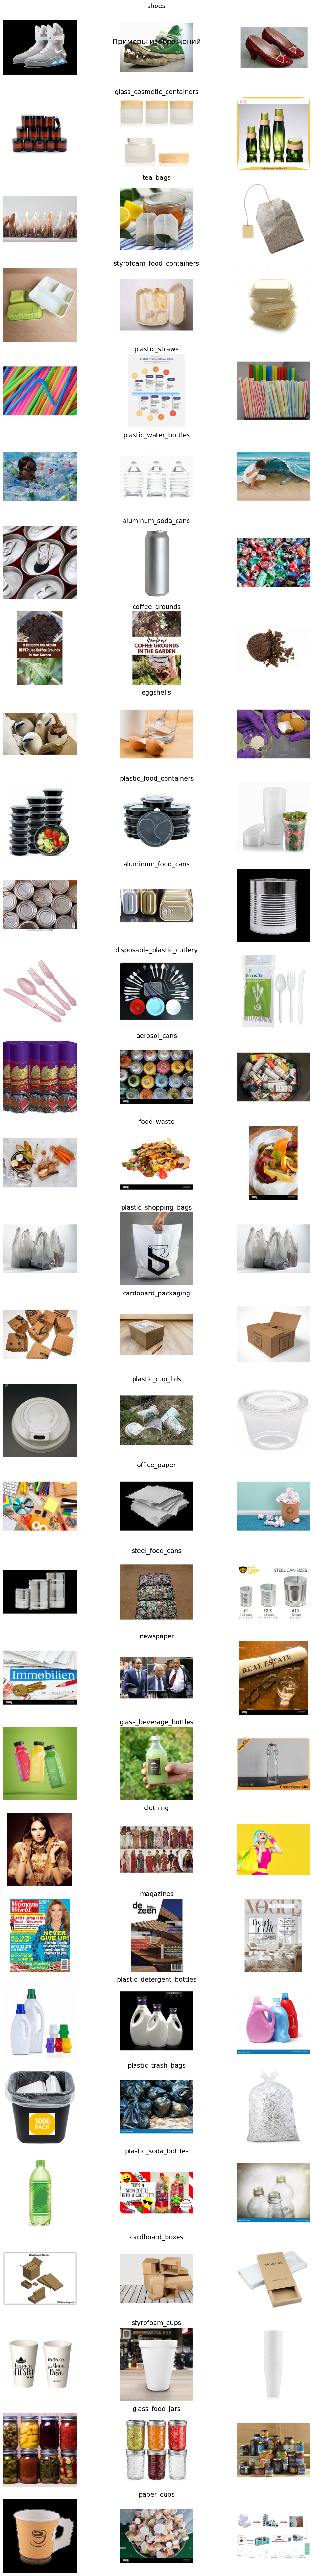

In [ ]:
source_of_samples = os.path.join(raw_dataset)
classes = os.listdir(source_of_samples)

fig, axes = plt.subplots(len(classes), 3, figsize=(12, 80))
fig.suptitle("Примеры изображений", fontsize=16)

for row, cls in enumerate(classes):

    class_dir = os.path.join(source_of_samples, cls, "real_world")
    images = os.listdir(class_dir)
    sample_imgs = random.sample(images, 3)

    for col, img_path in enumerate(sample_imgs):

        img_path = os.path.join(class_dir, img_path)
        img = Image.open(img_path)
        img = img.resize((224, 224))
        axes[row, col].imshow(img)
        axes[row, col].axis("off")

        if col == 1:
            axes[row, col].set_title(cls, fontsize=14)

plt.tight_layout()
plt.show()

### Достоинства рассматриваемого набора данных для обучения

#### 1.Классификация отходов основана на материальном составе и свойствах

Представленная система разделения отходов на семь категорий (Пластик, Бумага и Картон, Стекло, Металл, Органические отходы, Текстиль и Смешанные отходы) использует фундаментальный принцип классификации по материальному составу и физико-химическим свойствам, что непосредственно определяет технологические процессы их дальнейшей переработки, утилизации или захоронения [2]. Каждая категория имеет четкие критерии идентификации.

#### 2.Выделенные категории охватывают все основные виды отходов
Система включает следующие категории отходов:

1. Пластик
    * Критерии: Искусственные полимерные материалы различных типов (ПЭТ, ПВД, ПП и др.), определяющие технологию переработки [3].
    * Источники образования: бытовая упаковка (бутылки, пакеты, контейнеры), промышленная тара и упаковочные материалы торговых сетей.

2. Бумага и картон

    * Критерий: волокнистые материалы на основе целлюлозы с разделением по качеству волокна [4].
    * Источники образования: офисные учреждения (бумага для печати, архивы), торговая и логистическая сфера (картонная упаковка, транспортная тара), бытовые отходы (газеты, журналы).

3. Стекло

    * Критерий: хрупкие неорганические материалы на основе оксида кремния с сортировкой по цвету [5].
    * Источники образования: бытовая стеклянная тара (банки, бутылки), отходы предприятий общественного питания и торговли.

4. Металлы

    * Критерий: разделение на черные (железо, сталь) и цветные (алюминий, медь) металлы с различными технологиями переработки [6].
    * Источники образования: алюминиевые и жестяные банки, консервные банки, металлическая упаковка от бытовых потребителей, предприятий общепита и промышленности.

5. Органические отходы

    * Критерий: способность к биологическому разложению, отходы растительного и животного происхождения [7].
    * Источники образования: домашние хозяйства, предприятия общественного питания, торговли (просроченные продукты), садоводство и благоустройство территорий.

6. Текстиль

    * Критерий: изделия из натуральных и синтетических волокон с оценкой пригодности для повторного использования [8].
    * Источники образования: бытовые отходы (одежда, обувь, постельное белье), отходы швейного производства (обрезки тканей).

7. Смешанные отходы

    * Критерий: невозможность или нецелесообразность сортировки, комплексный состав [9].
    * Источники образования: загрязненные отходы, средства личной гигиены, композитные материалы и опасные отходы (батарейки, лампы) от всех секторов потребления.


#### 3.Система классификации соответствует международным и национальным стандартам



Разработанная система категоризации согласуется с основными регламентирующими документами, включая Европейский каталог отходов (EWC) [10] и Федеральный классификационный каталог отходов (ФККО) в России [11].

#### 4.Объем набора данных является достаточным для обучения.
 Поскольку количество примеров в каждом классе напрямую определяет итоговое качество нейросетевой модели, недостаточный размер выборки приведет к тому, что ее предсказания будут сопоставимы со случайным угадыванием. В рассматриваемом датасете каждый класс представлен более чем 500 уникальными изображениями, что удовлетворяет этому требованию [12].

### Недостатки рассматриваемого набора данных для обучения

#### 1.Несоответсвующая структура данных

В изначальном датасете структура файлов представлена следующим образом. Есть начальная папка в которой находится 30 категорий по папкам, которые также разделяются на 2 папки. Данная схема не подходит так как в ней отсутствуют подвыборки с данными для валидации и тестирования. Поэтому необходимо из основного набора сделать сделать подвыборки для тестирования и валидации а так же распределить данные в 7 необходимые категории.

#### 2.Неравномероное распределения данных по классам.
Количество изображений в различных классах демонстрирует значительный разброс - от 500 до 2000 экземпляров на категорию. Такой диапазон обусловлен объективной доступностью исходных данных для разных типов отходов, при этом даже минимальное количество в 500 изображений обеспечивает достаточную репрезентативность для обучения моделей машинного обучения.

### Промежуточный вывод на первом этапе
Выбранный набор данных лишён ключевых недостатков, присущих многим публичным коллекциям, поскольку содержит репрезентативные изображения, сделанные в реальных условиях, в достаточном для обучения объёме и актуальные для России. Заключительная часть работы будет посвящена нивелированию выявленных ограничений данного датасета.

## Этап 2 - Приведение датасета к привычной структуре.


#### 1.Изменение структуры данных
Изначальное необходимо изменить структуру данных, также сделав подвыборки test и validation для корректного обучения нейросети

In [ ]:
result_dataset = './result_dataset'

if os.path.exists(result_dataset):
    shutil.rmtree(result_dataset)

os.mkdir(result_dataset)

In [ ]:
for cat in categories:
    result_path = os.path.join(result_dataset, "DIR", cat)
    for v in categories[cat]:
        raw_path = os.path.join(raw_dataset, v)
        for h in ["default", "real_world"]:
            for i, filename in enumerate(os.listdir(os.path.join(raw_path, h))):
                source_path = os.path.join(raw_path, h, filename)
                if i%12 == 0:
                    path = result_path.replace("DIR", "Test")
                elif i%12 == 1:
                    path = result_path.replace("DIR", "Validation")
                else:
                    path = result_path.replace("DIR", "Train")
                os.makedirs(path, exist_ok=True)
                shutil.copy2(source_path, os.path.join(path, f"{v}_{i}.png"))

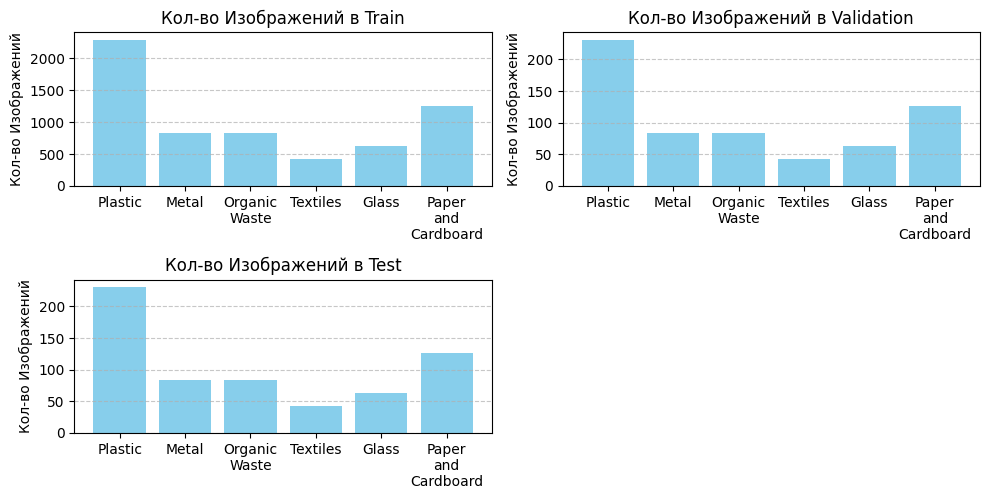

In [ ]:
count = {}

plt.figure(figsize=(10, 7))

for i, dir in enumerate(['Train', 'Validation', 'Test']):

    result_path = os.path.join(result_dataset, dir)
    diseases = os.listdir(result_path)
    count[dir] = {}

    for disease in diseases:

        images = os.path.join(result_path, disease)
        count[dir][disease] = len(os.listdir(images))

    plt.subplot(3, 2, 1 + i)
    labels = list(map(lambda s: s.replace(" ", "\n"), count[dir].keys()))
    plt.bar(labels, count[dir].values(), color='skyblue')
    plt.ylabel('Кол-во Изображений')
    plt.title(f'Кол-во Изображений в {dir}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.show()

Теперь необходимо сбалансировать количество изображений в каждом классе, так как он влечет негативные последствия для процесса обучения [13,14], например, модель начинает больше ориентироваться на классы с наибольшим числом примеров и практически игнорирует малые классы.

Теперь выполним балансировку тренировочной выборки. Для этого можно использовать технику аугментации. Можно применить разные подходы [15], например, подход weak-strong: для классов-меньшинств использовать более сильные аугментации, для классов-большинтсва - более слабые.

Чтобы опровобать подходы предлагаемые подходы, необходимо описать два вида трансформаций: сильные и слабые аугментации.

К набору слабых аугментаций (weak_aug) отнесем:

Масштабирвание (RandomResizedCrop, Affine)
Сдвиг (Affine)
Поворот (RandomRotate90, Affine)
Отражение (VerticalFlip, HorizontalFlip)
В набор сильнух аугментаций (strong_aug) войдут слабые и следующие:

Изменение яркости и контрастности (RandomBrightnessContrast, CLAHE)
Изменение оттенка (HueSaturationValue)
Размытие (GaussianBlur)

In [ ]:
strong_aug = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.75, 1.0), p=1),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.7),
    A.RandomRotate90(p=0.7),
    A.Affine(
        translate_percent=(0.15,0.15),
        scale=(0.75, 1.25),
        rotate=25,
        p=0.5
    ),
    A.RandomBrightnessContrast(0.3, 0.3, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.6),
    A.GaussianBlur(blur_limit=(1,3), p=0.3),
    A.CLAHE(clip_limit=3.0, p=0.3),
])

weak_aug = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.85, 0.95), p=1),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.7),
    A.RandomRotate90(p=0.9),
    A.Affine(
        translate_percent=(0.1, 0.1),
        scale=(0.9, 1.1),
        rotate=10,
        p=0.5
    ),
])

Теперь рализуем один из подходов - weak-strong. Для классов выполним преобразования чтобы сделать количество изображений в каждом примерно равным 2000.

In [ ]:
augmentation_scheduler = {
    # 'Plastic': (3, strong_aug),
    'Paper and Cardboard': (1, weak_aug),
    'Glass': (3, strong_aug),
    'Metal': (2, strong_aug),
    'Organic Waste': (2, weak_aug),
    'Textiles': (4, strong_aug)
}

In [ ]:
for disease, technique in augmentation_scheduler.items():
    multiplier, augment = technique

    path = os.path.join(result_dataset, 'Train', disease)
    images = os.listdir(path)
    images_loop = tqdm(images)

    for image in images_loop:

        img_path = os.path.join(path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for time in range(multiplier):

            augmented = augment(image=img)['image']
            out_path = os.path.join(path, f"augment_{time}_{image}")
            cv2.imwrite(out_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

        images_loop.set_description(f'Аугментация {disease}')

Аугментация Textiles: 100%|██████████| 416/416 [00:07<00:00, 54.13it/s]


Примеры аугментированных изображений в сравнении с оригиналом:

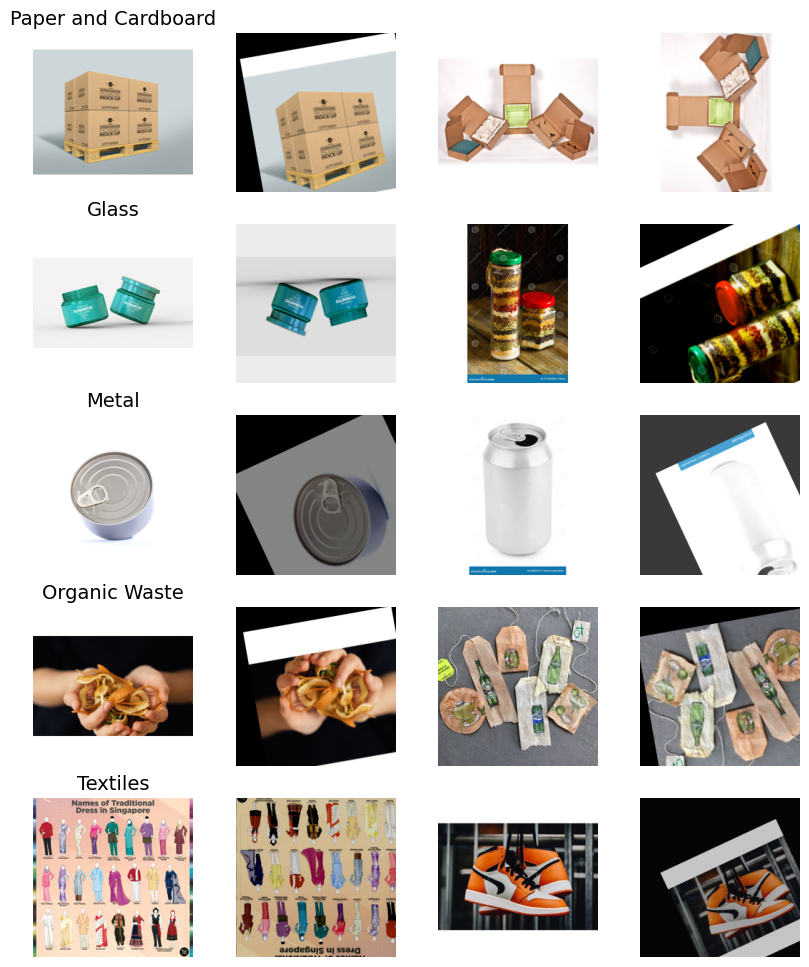

In [ ]:
fig, axes = plt.subplots(len(augmentation_scheduler.keys()), 4, figsize=(10, 12))

for row, item in enumerate(augmentation_scheduler.items()):
    key, plan = item
    path = os.path.join(result_dataset, 'Train', key)
    images = os.listdir(path)

    augmented_images = list(filter(lambda name: name.startswith('augment'), images))
    random.shuffle(augmented_images)

    for col in range(2):
        augmented_image_name = augmented_images[col]
        original_image_name = augmented_image_name[8:] #убераем augment_

        index_length = 0
        for char in original_image_name: #убераем index_
            index_length += 1
            if (char == '_'):
                break
        original_image_name = original_image_name[index_length:]

        original_image_path = os.path.join(path, original_image_name)
        original_image = Image.open(original_image_path).resize((224, 224))
        axes[row, 2*col].imshow(original_image)
        axes[row, 2*col].axis("off")

        augmented_image_path = os.path.join(path, augmented_image_name)
        augmented_image = Image.open(augmented_image_path).resize((224, 224))
        axes[row, 2*col + 1].imshow(augmented_image)
        axes[row, 2*col + 1].axis("off")

        if col == 0:
            axes[row, col].set_title(key, fontsize=14)

В ходе выполнения работы по подготовке обучающего набора данных, был выбран датасет, обладающий существенными преимуществами, которых нет среди прочих представленных датасетов. Имеющиеся при этом недостатаки не были критичными и поддавались исправлению. Так, теперь имеются выборки Train/Validation/Test, количество изображений в классах сбалансировано и приближено к 2000. Полученный набор данных пригоден для проведения обучения нейросетевой модели.

## Источники
1. www.kaggle.com - Recyclable and Household Waste Classification [Электронный ресурс]. - URL: <https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification/data>.
2. Technical Guideline TG-WM-09 Waste Classification. National Center for Waste Management (MWAN), Kingdom of Saudi Arabia. Riyadh, 2023. 48 p.
URL: https://istitlaa.ncc.gov.sa/en/civil/ncwm/technicalguidelineswasteclassification/Documents/TG-WM-09%20Waste%20Classiffication_FINAL_EN.pdf
3. Geyer R., Jambeck J. R., Law K. L. Production, use, and fate of all plastics ever made. Science Advances. 2017;3(7):e1700782.
URL: https://www.science.org/doi/10.1126/sciadv.1700782
4. Dalton F. C., Gardner D. J., Gramlich W. M. Cellulose nanomaterials in papermaking: A review of their properties, production, and applications. BioResources. 2020;15(3):7002–7046.
URL: https://bioresources.cnr.ncsu.edu/wp-content/uploads/2020/07/BioRes_15_3_7002_Dalton_Cellulose_Nanomaterials_Papermaking_Review_19669.pdf
5. Исследование переработки стеклобоя и энергоэффективности производства стекла в Российской Федерации. Glass-TS project. — [электронный ресурс]. — URL: https://www.glass-ts.com/site/assets/files/1015/russian_glass_recycling_project_stakeholder_dissemination_paper_rus.pdf
6. Panda A., Mishra S. C., Kumar S. Recycling of metals: A review. Materials Today: Proceedings. 2020. URL: https://www.sciencedirect.com/science/article/pii/S2214785320345710
7. Дорохов А. А. Раздельный сбор органических отходов: внедрение и реализация накопления и РСО. Экологическая инициатива. 2021.
URL: https://xn--80ahmgctc9ac5h.xn--p1acf/media/pdf_eco/TBO_04_2021_%D0%94%D0%BE%D1%80%D0%BE%D1%85%D0%BE%D0%B2.pdf
8. Орлова, О. В., Иванова, Н. С., Петров, А. А. Recycling and Sustainability of Textile Materials: Challenges and Opportunities // Polymers. — 2022. — Vol. 14, No. 19. — Article 3939. DOI: 10.3390/polym14193939. URL: https://www.mdpi.com/2073-4360/14/19/3939
9. Перечень отходов, не относящихся к твёрдым коммунальным отходам (ТКО).
Экоиндустрия. 2024.
URL: https://www.ecoindustry.ru/news/view/53315.html
10. Commission Decision (EU) 2018/850 of 3 July 2018 on the European Waste Catalogue. Official Journal of the European Union, C 124, 1–23.
URL: https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=uriserv:OJ.C_.2018.124.01.0001.01.ENG&toc=OJ:C:2018:124:TOC
11. Федеральный классификационный каталог отходов (ФККО). Росприроднадзор. URL: https://rpn.gov.ru/fkko/
12. Perez L., Wang J. The Effectiveness of Data Augmentation in Image Classification using Deep Learning. arXiv preprint arXiv:1712.04621. 2017.
URL: https://arxiv.org/abs/1712.04621
13. Leevy J.L. A survey on addressing high-class imbalance in big data / J.L. Leevy, T.M. Khoshgoftaar, R.A. Bauder, N. Seliya // Journal of Big Data. - 2018. - №5, 42. - 30 p. DOI: 10.1186/s40537-018-0151-6
14. Johnson J.M., Khoshgoftaar T.M. Survey on deep learning with class imbalance // Journal of Big Data. - 2019 №6, 27. - 54 p. DOI: 10.1186/s40537-019-0192-5
15. Schaudt D. Augmentation strategies for an imbalanced learning problem on a novel COVID-19 severity dataset / D. Schaudt, R. von Schwerin, A. Hafner, P. Riedel, M. Reichert, M. von Schwerin, M. Beer, C. Kloth // Scientific Reports. - 2023. №13, 18299. - 16 p. DOI: 10.1038/s41598-023-45532-2

In [ ]:
!zip -r archive.zip /content/result_dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: content/result_dataset/Train/Textiles/augment_0_clothing_202.png (deflated 39%)
  adding: content/result_dataset/Train/Textiles/augment_2_clothing_5.png (deflated 1%)
  adding: content/result_dataset/Train/Textiles/augment_1_shoes_165.png (deflated 1%)
  adding: content/result_dataset/Train/Textiles/augment_3_shoes_65.png (deflated 1%)
  adding: content/result_dataset/Train/Textiles/augment_3_shoes_9.png (deflated 1%)
  adding: content/result_dataset/Train/Textiles/augment_0_shoes_171.png (deflated 4%)
  adding: content/result_dataset/Train/Glass/ (stored 0%)
  adding: content/result_dataset/Train/Glass/augment_2_glass_beverage_bottles_243.png (deflated 2%)
  adding: content/result_dataset/Train/Glass/augment_1_glass_food_jars_57.png (deflated 0%)
  adding: content/result_dataset/Train/Glass/glass_cosmetic_containers_78.png (deflated 0%)
  adding: content/result_dataset/Train/Glass/augment_1_glass_cosmetic_co